In [1]:
import pandas as pd
import os
from PIL import Image
if os.getcwd().split(os.sep)[-1] == 'notebooks':
    os.chdir('..') # set/ ccwd as the parent directory to make imports easier
import json
import ast
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from serve.utils_llm import get_llm_output

In [2]:
dataset = pd.read_csv("data/benchmark/arena_friendly_and_cold_smaller.csv")
metrics = pd.read_json("pipeline_results/arena_friendly_and_cold_smaller/paired_cohns_kappa/LLMProposerMultiModel-ClusterSampler_5-MuliRubricRankerJury/A-B_k3_seed42-eval-metrics.json")
metrics["Cohen's Kappa (Judge 0 vs Judge 1)"] = metrics[["A Cohen's Kappa (Judge 0 vs Judge 1)", "B Cohen's Kappa (Judge 0 vs Judge 1)"]].apply(lambda x: x.mean(), axis=1)
metrics["Cohen's Kappa (Judge 0 vs Judge 2)"] = metrics[["A Cohen's Kappa (Judge 0 vs Judge 2)", "B Cohen's Kappa (Judge 0 vs Judge 2)"]].apply(lambda x: x.mean(), axis=1)
metrics["Cohen's Kappa (Judge 1 vs Judge 2)"] = metrics[["A Cohen's Kappa (Judge 1 vs Judge 2)", "B Cohen's Kappa (Judge 1 vs Judge 2)"]].apply(lambda x: x.mean(), axis=1)
print(metrics.columns)
selected_cols = ['axis', 'Judge_avg_A_mean_score',
       'Judge_avg_A_std_score', 'Judge_avg_A_mean_diff','Judge_avg_B_mean_score',
       'Judge_avg_B_std_score', 'support', 'topic', "Cohen's Kappa (Judge 0 vs Judge 1)", "Cohen's Kappa (Judge 0 vs Judge 2)", "Cohen's Kappa (Judge 1 vs Judge 2)"]
metrics = metrics[selected_cols]
metrics = metrics[np.abs(metrics['Judge_avg_A_mean_diff']) > 0.1]

chosen_axis = "Tone and Formality: High: Casual, personalized, and empathetic with frequent use of interjections and humor. Low: Professional, neutral, and factual without personalization."
metrics[metrics["axis"] == chosen_axis][[ 'topic', 'support', "Cohen's Kappa (Judge 0 vs Judge 1)", "Cohen's Kappa (Judge 0 vs Judge 2)", "Cohen's Kappa (Judge 1 vs Judge 2)"]]

Index(['axis', 'A Cohen's Kappa (Judge 0 vs Judge 1)',
       'A Cohen's Kappa (Judge 0 vs Judge 2)',
       'A Cohen's Kappa (Judge 1 vs Judge 2)', 'Judge_0_A_mean_score',
       'Judge_0_A_std_score', 'Judge_0_A_mean_diff', 'Judge_1_A_mean_score',
       'Judge_1_A_std_score', 'Judge_1_A_mean_diff', 'Judge_2_A_mean_score',
       'Judge_2_A_std_score', 'Judge_2_A_mean_diff', 'Judge_avg_A_mean_score',
       'Judge_avg_A_std_score', 'Judge_avg_A_mean_diff',
       'B Cohen's Kappa (Judge 0 vs Judge 1)',
       'B Cohen's Kappa (Judge 0 vs Judge 2)',
       'B Cohen's Kappa (Judge 1 vs Judge 2)', 'Judge_0_B_mean_score',
       'Judge_0_B_std_score', 'Judge_0_B_mean_diff', 'Judge_1_B_mean_score',
       'Judge_1_B_std_score', 'Judge_1_B_mean_diff', 'Judge_2_B_mean_score',
       'Judge_2_B_std_score', 'Judge_2_B_mean_diff', 'Judge_avg_B_mean_score',
       'Judge_avg_B_std_score', 'Judge_avg_B_mean_diff', 'support', 'topic',
       'Cohen's Kappa (Judge 0 vs Judge 1)',
       'Cohen's K

,topic,support,Cohen's Kappa (Judge 0 vs Judge 1),Cohen's Kappa (Judge 0 vs Judge 2),Cohen's Kappa (Judge 1 vs Judge 2)
2,Role-playing and correction,77,0.386635,0.367962,0.384544
3,Technical programming tasks,49,0.183401,0.269057,0.368260
4,Creative writing prompts,148,0.545122,0.560782,0.564449
5,Analytical reasoning,132,0.508170,0.614831,0.540040
6,Language and logic puzzles,44,0.259667,0.368228,0.397182


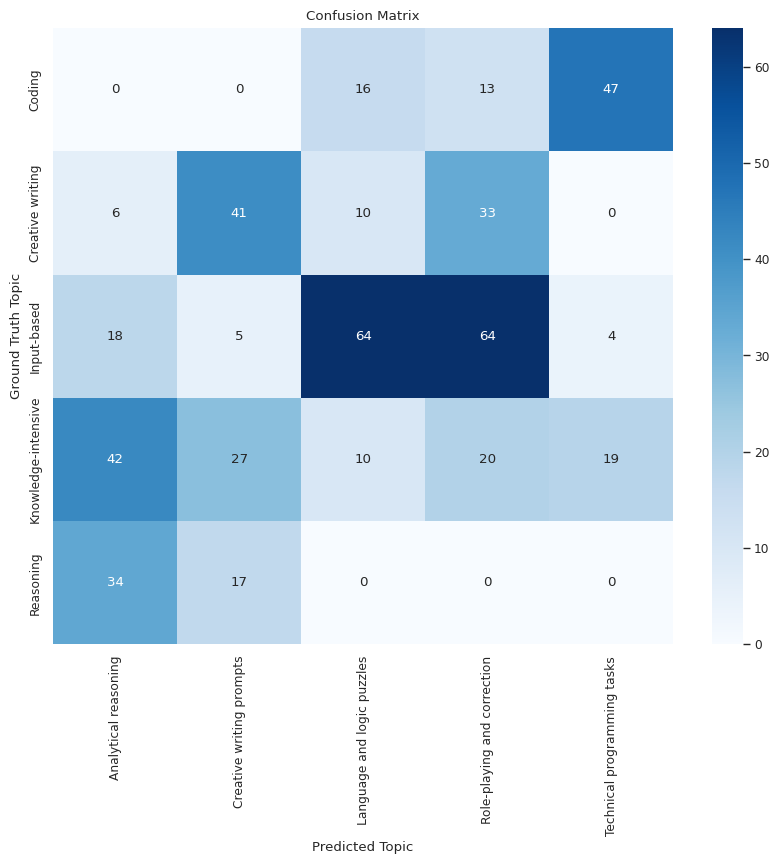

In [78]:
dataset = pd.read_csv("data/benchmark/arena_friendly_and_cold_smaller.csv")
df = pd.read_csv("pipeline_results/arena_friendly_and_cold_smaller/larger_clusters/LLMProposerMultiModel-ClusterSampler_5-MuliRubricRankerJury/A-B_k3_seed42-reducer_results.csv")
with open("pipeline_results/arena_friendly_and_cold_smaller/larger_clusters/LLMProposerMultiModel-ClusterSampler_5-MuliRubricRankerJury/A-B_k3_seed42-axes_to_topic.json") as f:
    axes_to_topic = json.load(f)
df = df.merge(dataset[["question", "category"]], on="question", how="left")

# Create a confusion matrix
confusion_matrix = pd.crosstab(df['category'], df['topic'], rownames=['Ground Truth'], colnames=['Predicted'])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Topic')
plt.ylabel('Ground Truth Topic')
plt.title('Confusion Matrix')
plt.show()

In [79]:
scores = pd.read_json("pipeline_results/arena_friendly_and_cold_smaller/paired_cohns_kappa/LLMProposerMultiModel-ClusterSampler_5-MuliRubricRankerJury/A-B_k3_seed42-eval-results.json")
scores['model_names'] = [["A", "B"]] * len(scores)
print(scores.columns)
scores_exploded = scores.explode([
       'model_names', 'Judge_0_score', 'Judge_0_diff_score','Judge_1_score', 'Judge_1_diff_score',
       'Judge_2_scores_reasoning', 'Judge_2_score', 'Judge_2_diff_score',
       'avg_scores', 'avg_diff_scores'])
scores_exploded.groupby(["axis", "topic", "model_names"])[["avg_diff_scores"]].std()
# get a hist of scores for each axis
# get a hist of scores for each topic
# axis = "Complexity and Detail: High: In-depth explanations, complex vocabulary, and technical details. Low: Simple language, concise, and to-the-point responses."
# topic = "Language and logic puzzles"
# def plot_score_distribution(axis, topic):
#     axis_topic_scores = scores_exploded[(scores_exploded["axis"] == axis) & (scores_exploded["topic"] == topic)]
#     # plot histograms of scores for model a and model b 
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     sns.histplot(axis_topic_scores[axis_topic_scores["model_names"] == "A"]["Judge_2_score"], ax=ax[0])
#     ax[0].set_title("Model A")
#     sns.histplot(axis_topic_scores[axis_topic_scores["model_names"] == "B"]["Judge_2_score"], ax=ax[1])
#     ax[1].set_title("Model B")
# plot_score_distribution(axis, topic)

Index(['question', 'A', 'B', 'embedding', 'topic', 'Judge_0_scores_reasoning',
       'Judge_0_score', 'Judge_0_diff_score', 'axis',
       'Judge_1_scores_reasoning', 'Judge_1_score', 'Judge_1_diff_score',
       'Judge_2_scores_reasoning', 'Judge_2_score', 'Judge_2_diff_score',
       'avg_scores', 'avg_diff_scores', 'model_names'],
      dtype='object')


avg_diff_scores
axis                                               topic                       model_names                 
Complexity and Detail: High: In-depth explanati... Language and logic puzzles  A                   0.292615
                                                                               B                   0.292615
                                                   Technical programming tasks A                   0.259048
                                                                               B                   0.259048
Engagement and Interaction: High: Conversationa... Analytical reasoning        A                   0.586937
                                                                               B                   0.586937
                                                   Creative writing prompts    A                   0.556743
                                                                               B                   0.556743
                                                   Language and logic puzzles  A                   0.449074
                                                                               B                   0.449074
                                                   Role-playing and correction A                   0.316669
                                                                               B                   0.316669
                                                   Technical programming tasks A                   0.296586
                                                                               B                   0.296586
Problem Solving and Adaptability: High: Offers ... Analytical reasoning        A                   0.280673
                                                                               B                   0.280673
                                                   Language and logic puzzles  A                   0.222897
                                                                               B                   0.222897
Response Structure and Clarity: High: Organized... Creative writing prompts    A                   0.273793
                                                                               B                   0.273793
Tone and Formality: High: Casual, personalized,... Analytical reasoning        A                   1.153673
                                                                               B                   1.153673
                                                   Creative writing prompts    A                   0.976967
                                                                               B                   0.976967
                                                   Language and logic puzzles  A                   0.704444
                                                                               B                   0.704444
                                                   Role-playing and correction A                   0.463924
                                                                               B                   0.463924
                                                   Technical programming tasks A                   0.523742
                                                                               B                   0.523742

['Complexity and Detail: High: In-depth explanations, complex vocabulary, and technical details. Low: Simple language, concise, and to-the-point responses.'
 'Tone and Formality: High: Casual, personalized, and empathetic with frequent use of interjections and humor. Low: Professional, neutral, and factual without personalization.'
 'Engagement and Interaction: High: Conversational with questions, enthusiastic commentary, and detailed step-by-step guidance. Low: Straightforward, direct answers with minimal elaboration.'
 'Response Structure and Clarity: High: Organized, with clear step-by-step instructions and unique narratives. Low: Less structured, with direct and brief information.'
 'Problem Solving and Adaptability: High: Offers multiple solutions, tailored advice, and shows a playful approach to logic. Low: Straightforward solutions with a direct analytical reasoning and general advice.']


Text(0.5, 0, 'Vibe Difference\n+ = friendly model fits the high vibe better\n- = cold model fits the high vibe better')

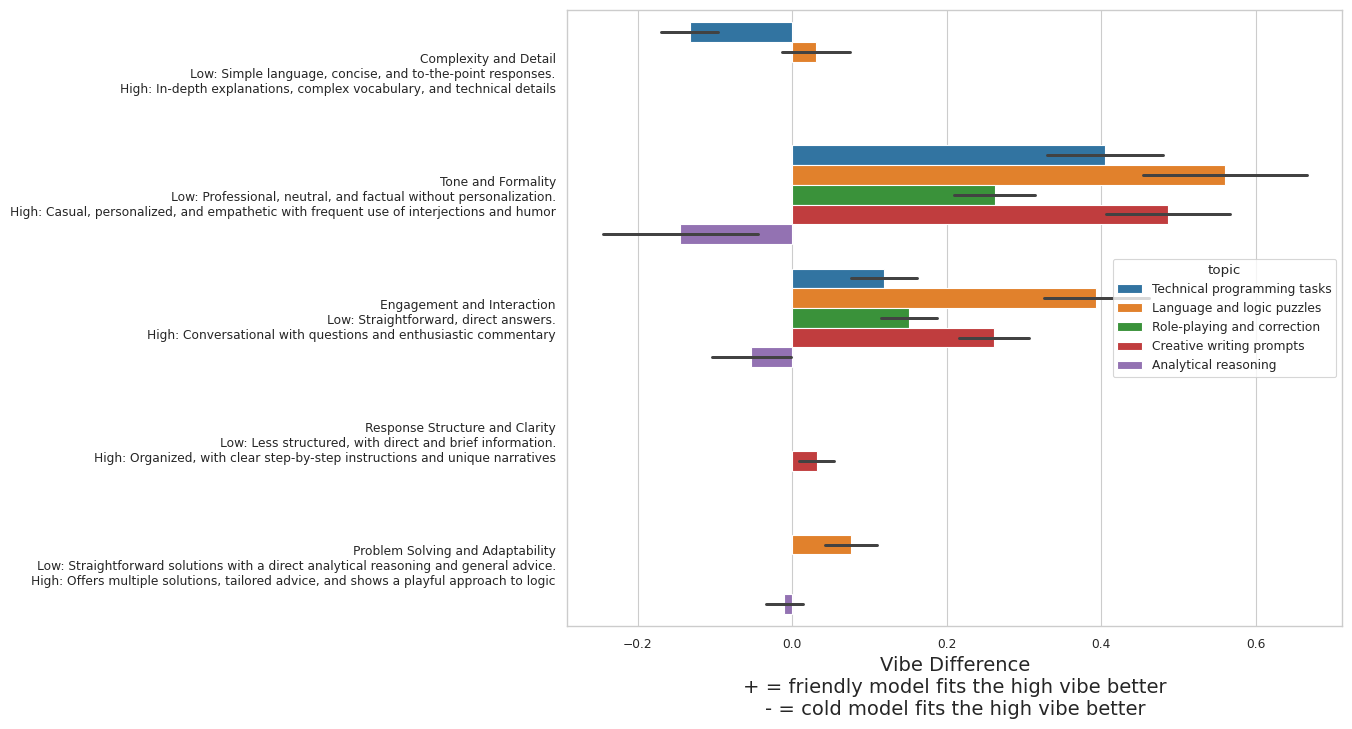

In [80]:
axis_converstion = {
    'Complexity and Detail: High: In-depth explanations, complex vocabulary, and technical details. Low: Simple language, concise, and to-the-point responses.': 'Complexity and Detail\nLow: Simple language, concise, and to-the-point responses.\nHigh: In-depth explanations, complex vocabulary, and technical details',
    "Tone and Formality: High: Casual, personalized, and empathetic with frequent use of interjections and humor. Low: Professional, neutral, and factual without personalization.": 'Tone and Formality\nLow: Professional, neutral, and factual without personalization.\nHigh: Casual, personalized, and empathetic with frequent use of interjections and humor',
    "Engagement and Interaction: High: Conversational with questions, enthusiastic commentary, and detailed step-by-step guidance. Low: Straightforward, direct answers with minimal elaboration.": 'Engagement and Interaction\nLow: Straightforward, direct answers.\nHigh: Conversational with questions and enthusiastic commentary',
    "Response Structure and Clarity: High: Organized, with clear step-by-step instructions and unique narratives. Low: Less structured, with direct and brief information.": 'Response Structure and Clarity\nLow: Less structured, with direct and brief information.\nHigh: Organized, with clear step-by-step instructions and unique narratives',
    "Problem Solving and Adaptability: High: Offers multiple solutions, tailored advice, and shows a playful approach to logic. Low: Straightforward solutions with a direct analytical reasoning and general advice.": 'Problem Solving and Adaptability\nLow: Straightforward solutions with a direct analytical reasoning and general advice.\nHigh: Offers multiple solutions, tailored advice, and shows a playful approach to logic'
}
scores = pd.read_json("pipeline_results/arena_friendly_and_cold_smaller/paired_cohns_kappa/LLMProposerMultiModel-ClusterSampler_5-MuliRubricRankerJury/A-B_k3_seed42-eval-results.json")
scores["diff"] = scores["avg_diff_scores"].apply(lambda x: x[0])
scores["judge_2_diff"] = scores["Judge_2_diff_score"].apply(lambda x: x[0])
scores["axis_short"] = scores["axis"].apply(lambda x: axis_converstion[x])
print(scores["axis"].unique())
scores.groupby(["axis", "topic"], as_index=False)[["diff"]].mean()
# set figsize
plt.figure(figsize=(10, 8))
# left justify the 
ax = sns.barplot(data=scores, y="axis_short", x="diff", hue="topic", errorbar="se") 
ax.set_ylabel("")
ax.set_xlabel("Vibe Difference\n+ = friendly model fits the high vibe better\n- = cold model fits the high vibe better", fontsize=14)

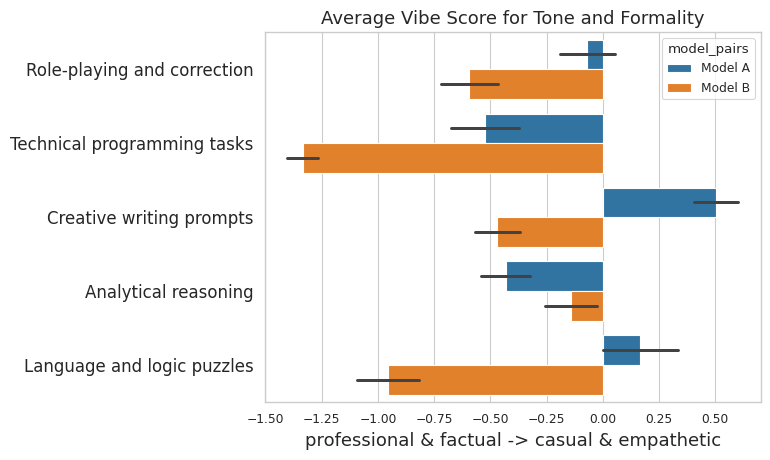

In [81]:
# set whitegrid paper style
sns.set_style("whitegrid")
sns.set_context("paper")
chosen_axis = "Tone and Formality: High: Casual, personalized, and empathetic with frequent use of interjections and humor. Low: Professional, neutral, and factual without personalization."
scores["model_pairs"] = [["Model A", "Model B"]] * len(scores)
scores_axis = scores[scores["axis"] == chosen_axis]
scores_exploded = scores_axis.explode([
       'model_pairs', 'Judge_0_score', 'Judge_0_diff_score','Judge_1_score', 'Judge_1_diff_score',
       'Judge_2_scores_reasoning', 'Judge_2_score', 'Judge_2_diff_score',
       'avg_scores', 'avg_diff_scores'])
ax = sns.barplot(data=scores_exploded, x="avg_scores", y="topic", hue="model_pairs", errorbar="se")
ax.set_ylabel("")
ax.set_title("Average Vibe Score for Tone and Formality", fontsize=13)
plt.yticks(fontsize=12)
ax.set_xlabel("professional & factual -> casual & empathetic", fontsize=13)
plt.savefig("figs/arena_benchmark_tone_formality.pdf", bbox_inches="tight")

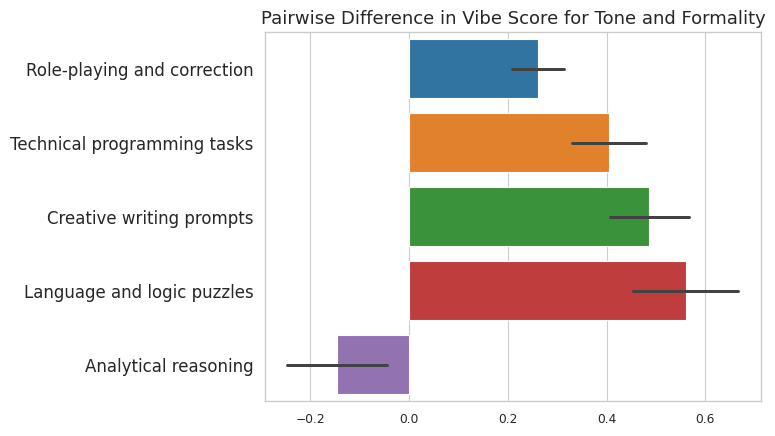

In [93]:
chosen_axis = "Tone and Formality: High: Casual, personalized, and empathetic with frequent use of interjections and humor. Low: Professional, neutral, and factual without personalization."
scores["model_pairs"] = [["Model A", "Model B"]] * len(scores)
scores_axis = scores[scores["axis"] == chosen_axis]
ylable_order = ['Role-playing and correction', 'Technical programming tasks', 'Creative writing prompts','Language and logic puzzles', 'Analytical reasoning']
ax = sns.barplot(data=scores_axis, x="diff", y="topic", errorbar="se", order=ylable_order)
ax.set_ylabel("")
ax.set_title("Pairwise Difference in Vibe Score for Tone and Formality", fontsize=13)
plt.yticks(fontsize=12)
ax.set_xlabel("", fontsize=0)
plt.savefig("figs/arena_benchmark_tone_formality_diff.pdf", bbox_inches="tight")

In [68]:
centroids = np.load("pipeline_results/arena_friendly_and_cold_smaller/paired_cohns_kappa/LLMProposerMultiModel-ClusterSampler_5-MuliRubricRankerJury/A-B_k3_seed42-topic-centroids.np.npy", allow_pickle=True).item()

# turn this into a dict
np.array(centroids['centroids']).shape

(5, 768)

In [95]:
print(plt.rcParams['font.family'])

['sans-serif']


In [5]:
dataset = pd.read_csv("data/benchmark/arena_friendly_and_cold_smaller.csv")
metrics = pd.read_json("pipeline_results/arena_friendly_and_cold_smaller/no_rubric_ton/LLMProposerMultiModel-ClusterSampler_5-JuryRanker/A-B_k3_seed42_axes_provided-eval-metrics.json")
metrics["Cohen's Kappa (Judge 0 vs Judge 1)"] = metrics[["A Cohen's Kappa (Judge 0 vs Judge 1)", "B Cohen's Kappa (Judge 0 vs Judge 1)"]].apply(lambda x: x.mean(), axis=1)
metrics["Cohen's Kappa (Judge 0 vs Judge 2)"] = metrics[["A Cohen's Kappa (Judge 0 vs Judge 2)", "B Cohen's Kappa (Judge 0 vs Judge 2)"]].apply(lambda x: x.mean(), axis=1)
metrics["Cohen's Kappa (Judge 1 vs Judge 2)"] = metrics[["A Cohen's Kappa (Judge 1 vs Judge 2)", "B Cohen's Kappa (Judge 1 vs Judge 2)"]].apply(lambda x: x.mean(), axis=1)
selected_cols = ['axis', 'Judge_avg_A_mean_score',
       'Judge_avg_A_std_score', 'Judge_avg_A_mean_diff','Judge_avg_B_mean_score',
       'Judge_avg_B_std_score', 'support', 'topic', "Cohen's Kappa (Judge 0 vs Judge 1)", "Cohen's Kappa (Judge 0 vs Judge 2)", "Cohen's Kappa (Judge 1 vs Judge 2)"]
metrics = metrics[selected_cols]
print(metrics.columns)
# metrics = metrics[np.abs(metrics['Judge_avg_A_mean_diff']) > 0.1]

chosen_axis = "Tone and Formality: High: Casual, personalized, and empathetic with frequent use of interjections and humor. Low: Professional, neutral, and factual without personalization."
metrics[metrics["axis"] == chosen_axis][[ 'topic', 'support', "Cohen's Kappa (Judge 0 vs Judge 1)", "Cohen's Kappa (Judge 0 vs Judge 2)", "Cohen's Kappa (Judge 1 vs Judge 2)"]]

Index(['axis', 'Judge_avg_A_mean_score', 'Judge_avg_A_std_score',
       'Judge_avg_A_mean_diff', 'Judge_avg_B_mean_score',
       'Judge_avg_B_std_score', 'support', 'topic',
       'Cohen's Kappa (Judge 0 vs Judge 1)',
       'Cohen's Kappa (Judge 0 vs Judge 2)',
       'Cohen's Kappa (Judge 1 vs Judge 2)'],
      dtype='object')


,topic,support,Cohen's Kappa (Judge 0 vs Judge 1),Cohen's Kappa (Judge 0 vs Judge 2),Cohen's Kappa (Judge 1 vs Judge 2)
0,Technical programming tasks,49,-0.018375,0.025678,0.025126
1,Role-playing and correction,77,0.033504,0.074718,0.036500
2,Analytical reasoning,132,-0.108911,0.161651,0.051332
3,Language and logic puzzles,44,-0.072849,0.110201,-0.010253
4,Creative writing prompts,148,-0.027064,0.189616,0.057873


In [6]:
metrics[['axis', 'topic', 'Judge_avg_A_mean_diff']]

,axis,topic,Judge_avg_A_mean_diff
0,"Tone and Formality: High: Casual, personalized...",Technical programming tasks,0.244898
1,"Tone and Formality: High: Casual, personalized...",Role-playing and correction,0.166667
2,"Tone and Formality: High: Casual, personalized...",Analytical reasoning,-0.029040
3,"Tone and Formality: High: Casual, personalized...",Language and logic puzzles,0.405303
4,"Tone and Formality: High: Casual, personalized...",Creative writing prompts,0.333333


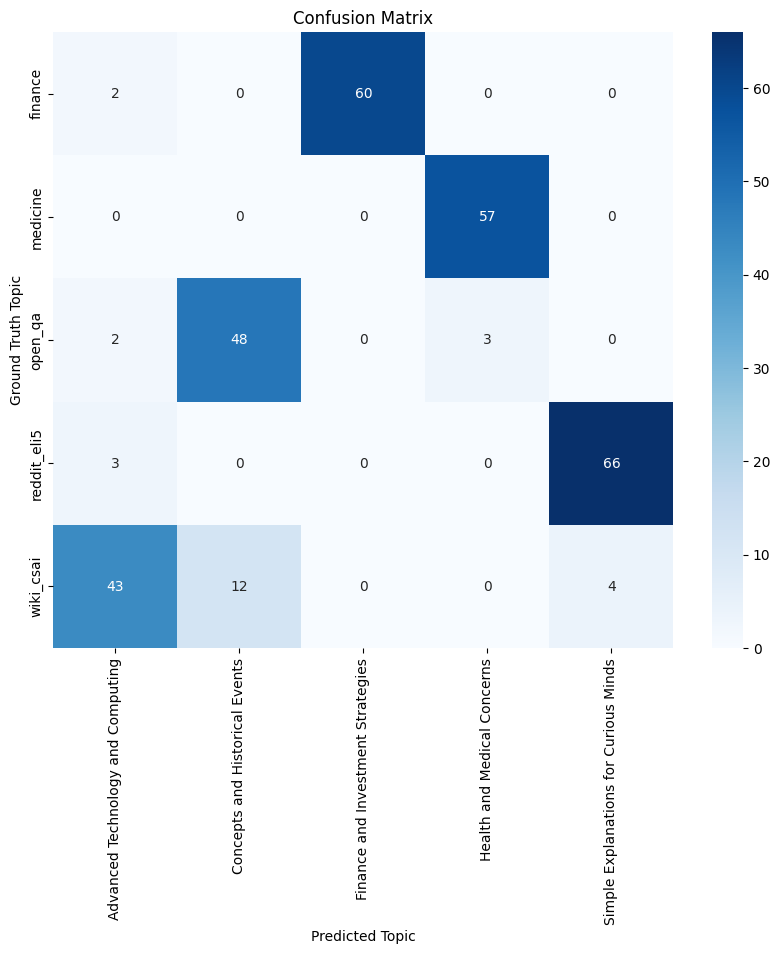

In [34]:
dataset = pd.read_csv("data/gpt_vs_human/multisource_testing.csv")
df = pd.read_csv("pipeline_results/multisource_testing/human_vs_gpt/LLMProposerMultiModel-ClusterSampler_5-MuliRubricRankerJury/human_answers-chatgpt_answers_k3_seed42-reducer_results.csv")
with open("pipeline_results/multisource_testing/LLMProposerMultiModel-ClusterSampler-AxisReducer-MuliRubricRankerJury/human_answers-chatgpt_answers_k3_seed42-axes_to_topic.json") as f:
    axes_to_topic = json.load(f)
df = df.merge(dataset[["question", "source"]], on="question", how="left")

# Create a confusion matrix
confusion_matrix = pd.crosstab(df['source'], df['topic'], rownames=['Ground Truth'], colnames=['Predicted'])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Topic')
plt.ylabel('Ground Truth Topic')
plt.title('Confusion Matrix')
# plt.show()
plt.savefig("figs/gpt_vs_human_confusion_topic_matrix.pdf", bbox_inches="tight")

In [43]:
metrics = pd.read_json("pipeline_results/multisource_testing/human_vs_gpt/LLMProposerMultiModel-ClusterSampler_5-MuliRubricRankerJury/human_answers-chatgpt_answers_k3_seed42-eval-metrics.json")
scores = pd.read_json("pipeline_results/multisource_testing/human_vs_gpt/LLMProposerMultiModel-ClusterSampler_5-MuliRubricRankerJury/human_answers-chatgpt_answers_k3_seed42-eval-results.json")
metric = [p for p in metrics.columns if "mean_diff" in p and "avg" in p][0]
p_val = [p for p in metrics.columns if "p_value" in p][0]
kappas = [p for p in metrics.columns if "Cohen's Kappa" in p and "0" in p]
metrics["Cohn's kappa mean"] = metrics[kappas].mean(axis=1)
summary_metrics = metrics[["topic", "axis", "support", metric, p_val, "Cohn's kappa mean"]].sort_values(metric)
columns = ['topic', 'vibe', 'support', 'Vibe Delta',
       'p-value', "Cohn's kappa mean"]
# round metric and pval to 3 decimal places
summary_metrics[metric] = summary_metrics[metric].apply(lambda x: round(x, 3))
summary_metrics[p_val] = summary_metrics[p_val].apply(lambda x: round(x, 3))
summary_metrics.columns = columns
summary_metrics

,topic,vibe,support,Vibe Delta,p-value,Cohn's kappa mean
1,Health and Medical Concerns,Detail and Specificity: High: 'Detailed and co...,105,-0.538,0.000,0.275843
4,Concepts and Historical Events,Detail and Specificity: High: 'Detailed and co...,121,-0.449,0.000,0.349447
2,Finance and Investment Strategies,Detail and Specificity: High: 'Detailed and co...,98,-0.400,0.000,0.252677
8,Advanced Technology and Computing,Use of Examples and Analogies: High: 'Frequent...,74,-0.151,0.034,0.170557
0,Advanced Technology and Computing,Detail and Specificity: High: 'Detailed and co...,74,-0.054,0.183,0.184050
6,Finance and Investment Strategies,Confidence and Assertiveness: High: 'Definitiv...,98,-0.041,0.452,0.202646
3,Simple Explanations for Curious Minds,Detail and Specificity: High: 'Detailed and co...,102,-0.034,0.476,0.295115
7,Simple Explanations for Curious Minds,Use of Examples and Analogies: High: 'Frequent...,102,0.067,0.235,0.192049
5,Health and Medical Concerns,Confidence and Assertiveness: High: 'Definitiv...,105,0.151,0.001,0.124067


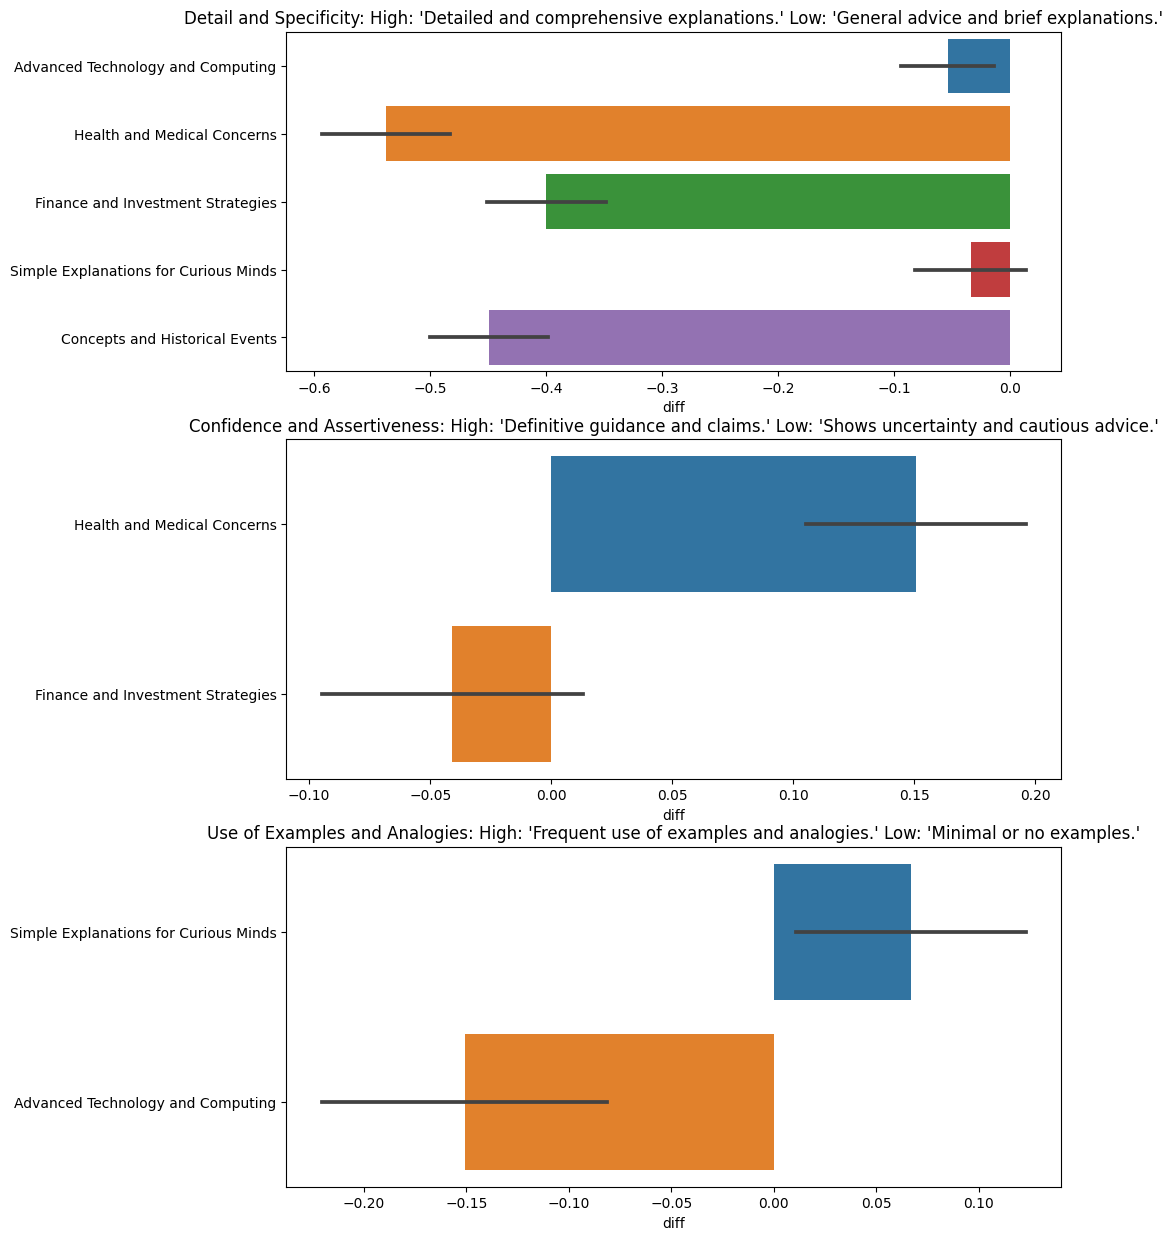

In [33]:
scores.columns
scores["diff"] = scores["avg_diff_scores"].apply(lambda x: x[0])
fig, axs = plt.subplots(len(scores["axis"].unique()), 1, figsize=(10, 15))
for i, axis in enumerate(scores["axis"].unique()):
    scores_topic = scores[scores["axis"] == axis]
    ax = sns.barplot(data=scores_topic, x="diff", y="topic", errorbar="se", ax=axs[i])
    ax.set_title(axis)
    ax.set_ylabel("")

In [ ]:
metrics = pd.read_json("pipeline_results/multisource_testing/human_vs_gpt/LLMProposerMultiModel-ClusterSampler_5-MuliRubricRankerJury/human_answers-chatgpt_answers_k3_seed42-eval-metrics.json")
scores = pd.read_json("pipeline_results/multisource_testing/human_vs_gpt/LLMProposerMultiModel-ClusterSampler_5-MuliRubricRankerJury/human_answers-chatgpt_answers_k3_seed42-eval-results.json")
metric = [p for p in metrics.columns if "mean_diff" in p and "avg" in p][0]
p_val = [p for p in metrics.columns if "p_value" in p][0]
kappas = [p for p in metrics.columns if "Cohen's Kappa" in p and "0" in p]
metrics["Cohn's kappa mean"] = metrics[kappas].mean(axis=1)
summary_metrics = metrics[["topic", "axis", "support", metric, p_val, "Cohn's kappa mean"]].sort_values(metric)
columns = ['topic', 'vibe', 'support', 'Vibe Delta',
       'p-value', "Cohn's kappa mean"]
# round metric and pval to 3 decimal places
summary_metrics[metric] = summary_metrics[metric].apply(lambda x: round(x, 3))
summary_metrics[p_val] = summary_metrics[p_val].apply(lambda x: round(x, 3))
summary_metrics.columns = columns
summary_metrics